<a href="https://colab.research.google.com/github/meltyyyyy/kaggle-amex/blob/main/Notebooks/CatBoost/Aggregation001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
class Config:
    name = "CatBoost/Aggregation001"

    n_splits = 5
    seed = 2022
    target = "target"

    # Colab Env
    upload_from_colab = True
    api_path = "/content/drive/MyDrive/workspace/kaggle.json"
    drive_path = "/content/drive/MyDrive/workspace/kaggle-amex"
    
    # Kaggle Env
    kaggle_dataset_path = None

In [ ]:
import os
import json
import warnings
import shutil
import logging
import joblib
import random
import datetime
import sys
import gc
import multiprocessing
import joblib
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
warnings.filterwarnings('ignore')

In [ ]:
COLAB = "google.colab" in sys.modules
if COLAB:
    print("This environment is Google Colab")
    
    # mount
    from google.colab import drive
    if not os.path.isdir("/content/drive"):
        drive.mount('/content/drive') 
	
    # import library
    ! pip install --quiet catboost
    # ! pip install --quiet iterative-stratification
    # ! pip install --quiet tensorflow-addons

    # use kaggle api (need kaggle token)
    f = open(Config.api_path, 'r')
    json_data = json.load(f) 
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]
    
    # set dirs
    DRIVE = Config.drive_path
    EXP = (Config.name if Config.name is not None 
           else get("http://172.28.0.2:9000/api/sessions").json()[0]["name"][:-6])
    INPUT = os.path.join(DRIVE, "Input")
    OUTPUT = os.path.join(DRIVE, "Output")
    SUBMISSION = os.path.join(DRIVE, "Submission")
    OUTPUT_EXP = os.path.join(OUTPUT, EXP) 
    EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
    EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
    EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")

    # make dirs
    for d in [INPUT, SUBMISSION, EXP_MODEL, EXP_FIG, EXP_PREDS]:
        os.makedirs(d, exist_ok=True)

    # if not os.path.isfile(os.path.join(INPUT, "amex-default-prediction.zip")):
        # load dataset
        # ! kaggle competitions download -c amex-default-prediction -p $INPUT 
else:
    print("This environment is Kaggle Kernel")
    
    # set dirs
    INPUT = "../input/amex-default-prediction"
    EXP, OUTPUT, SUBMISSION = "./", "./", "./"
    EXP_MODEL = os.path.join(EXP, "model")
    EXP_FIG = os.path.join(EXP, "fig")
    EXP_PREDS = os.path.join(EXP, "preds")
    
    # copy dirs
    if Config.kaggle_dataset_path is not None:
        KD_MODEL = os.path.join(Config.kaggle_dataset_path, "model")
        KD_EXP_PREDS = os.path.join(Config.kaggle_dataset_path, "preds")
        shutil.copytree(KD_MODEL, EXP_MODEL)
        shutil.copytree(KD_EXP_PREDS, EXP_PREDS)

    # make dirs
    for d in [EXP_MODEL, EXP_FIG, EXP_PREDS]:
        os.makedirs(d, exist_ok=True)


This environment is Google Colab


In [ ]:
train = pd.read_pickle(os.path.join(INPUT, 'train_agg.pkl'), compression="gzip")
test = pd.read_pickle(os.path.join(INPUT, 'test_agg.pkl'), compression="gzip")

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 458913 entries, 0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a to fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681
Columns: 919 entries, P_2_mean to target
dtypes: category(2), float16(713), float64(178), int64(22), int8(4)
memory usage: 1.3 GB


In [ ]:
train.head()

,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,...,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.933594,0.024194,0.868652,0.960449,0.934570,0.010704,0.024440,0.001082,0.091492,0.009117,...,13,O,1,0,NaN,0,13,6.0,1,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.899902,0.022097,0.861328,0.929199,0.880371,0.215210,0.199123,0.002224,0.567383,0.178101,...,13,O,1,0,NaN,0,13,6.0,1,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.878418,0.028837,0.797852,0.904297,0.880859,0.004181,0.002759,0.000802,0.009705,0.009705,...,13,R,1,0,NaN,0,13,6.0,1,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.599121,0.020082,0.567383,0.623535,0.621582,0.048859,0.088490,0.000660,0.268555,0.001082,...,13,O,1,0,NaN,0,13,3.0,3,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.891602,0.042316,0.805176,0.940430,0.872070,0.004642,0.002883,0.000030,0.008682,0.005573,...,13,O,1,13,1.0,1,13,6.0,1,0


## Evaluation merics

In [ ]:
# https://www.kaggle.com/code/inversion/amex-competition-metric-python

def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

class AmexMetric(object):
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        # the larger metric value the better
        return True

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])
        preds = np.array(approxes[0])
        target = np.array(target)
        return amex_metric(pd.DataFrame({'target': target}), pd.Series(preds, name='prediction')), 0

## Preprocess

In [ ]:
float64_cols = [col for col in train.columns if train[col].dtype == 'float64']
int64_cols = [col for col in train.columns if train[col].dtype == 'int64']

print(train.info())
print(test.info())
print()
print("-"*50+f' data type transformation '+'-'*50)
print()

def transform_dtype(df):
  for col in df.columns:
    if df[col].dtype == 'float64':
      df[col] = df[col].astype('float16')
    if df[col].dtype == 'float32':
      df[col] = df[col].astype('float16')
    if df[col].dtype == 'int64':
      df[col] = df[col].astype('int8')
    if df[col].dtype == 'int32':
      df[col] = df[col].astype('int8')
  return df

train = transform_dtype(train)
test = transform_dtype(test)

print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 458913 entries, 0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a to fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681
Columns: 919 entries, P_2_mean to target
dtypes: category(2), float16(713), float64(178), int64(22), int8(4)
memory usage: 1.3 GB
None
<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 924621 entries, 00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7 to fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61cceb803ea8ec37634d
Columns: 918 entries, P_2_mean to D_68_nunique
dtypes: category(2), float16(713), float64(178), int32(3), int64(22)
memory usage: 2.7 GB
None

-------------------------------------------------- data type transformation --------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 458913 entries, 0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a to fffff1d38b785cef84adeace64f8f83db3a0c31e8d92

## Select features to use

In [ ]:
from sklearn.preprocessing import LabelEncoder

features = []
unuse = ['target']
cat_features = [
    "B_30",
    "B_38",
    "D_114",
    "D_116",
    "D_117",
    "D_120",
    "D_126",
    "D_63",
    "D_64",
    "D_66",
    "D_68"
]
cat_features = [f"{cf}_last" for cf in cat_features]

encoder = LabelEncoder()
for categorical_feature in cat_features:
    train[categorical_feature] = encoder.fit_transform(train[categorical_feature])
    test[categorical_feature] = encoder.transform(test[categorical_feature])

for col in train.columns:
  if col not in unuse:
    features.append(col)

## Training

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold

def fit_catboost(X, y, cat_features=None, params=None):
  models = []
  scores = []

  skf = StratifiedKFold(n_splits=Config.n_splits, shuffle=True, random_state=Config.seed)
  
  for fold, (train_indices, valid_indices) in enumerate(tqdm(skf.split(X, y))):
    print("-"*50+f' fold{fold} '+'-'*50)
    X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
    X_valid, y_valid = X.iloc[valid_indices], y.iloc[valid_indices]

    model = CatBoostClassifier(**params,
                              #  eval_metric=AmexMetric(),
                               task_type='GPU',
                               iterations=10000,
                               random_seed=Config.seed,
                               verbose=0)
    
    model.fit(X_train, y_train,
              cat_features=cat_features,
              eval_set=[(X_valid, y_valid)],
              early_stopping_rounds=10,
              verbose_eval=50)
    
    # ------------------- prediction -------------------
    pred = model.predict_proba(X_valid)[:, 1]
    score = amex_metric(pd.DataFrame({'target': y_valid.values}), pd.Series(pred, name='prediction'))

    # ------------------- save -------------------
    file = f'{EXP_MODEL}/catboost_fold{fold}.pkl'
    model.save_model(file, format='cbm')
    scores.append(score)
    models.append(model)
    print(f'fold{fold} amex meric: {score}')
    print()

  print(f"OOF Score: {np.mean(scores):.5f}")
  return models

def inference_catboost(models, X):
    pred = np.array([model.predict_proba(X) for model in models])
    pred = np.mean(pred, axis=0)[:, 1]
    return pred

In [ ]:
cat_params = {"learning_rate": 0.01}

models = fit_catboost(train[features], train[Config.target], cat_features=cat_features, params=cat_params)
# models = [joblib.load(f'{EXP_MODEL}/lgbm_fold{i}.pkl') for i in range(Config.n_splits)]
pred = inference_catboost(models, test[features])

0it [00:00, ?it/s]

-------------------------------------------------- fold0 --------------------------------------------------
0:	learn: 0.6803427	test: 0.6804192	best: 0.6804192 (0)	total: 71.6ms	remaining: 11m 55s
50:	learn: 0.3656400	test: 0.3676416	best: 0.3676416 (50)	total: 3.45s	remaining: 11m 13s
100:	learn: 0.2893912	test: 0.2919507	best: 0.2919507 (100)	total: 6.79s	remaining: 11m 5s
150:	learn: 0.2630305	test: 0.2657963	best: 0.2657963 (150)	total: 10.1s	remaining: 10m 57s
200:	learn: 0.2503466	test: 0.2533000	best: 0.2533000 (200)	total: 13.4s	remaining: 10m 53s
250:	learn: 0.2433613	test: 0.2464820	best: 0.2464820 (250)	total: 16.7s	remaining: 10m 47s
300:	learn: 0.2389606	test: 0.2422275	best: 0.2422275 (300)	total: 20s	remaining: 10m 43s
350:	learn: 0.2359608	test: 0.2393488	best: 0.2393488 (350)	total: 23.2s	remaining: 10m 37s
400:	learn: 0.2337912	test: 0.2373006	best: 0.2373006 (400)	total: 26.4s	remaining: 10m 33s
450:	learn: 0.2320709	test: 0.2356852	best: 0.2356852 (450)	total: 29.7s

## Plot importances

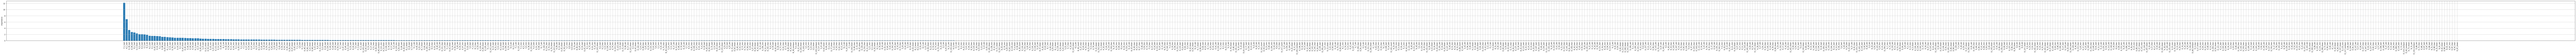

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

## Submission

In [ ]:
sub = pd.DataFrame({'customer_ID': test.index,
                    'prediction': pred})
sub.to_csv(f'{SUBMISSION}/submission.csv', index=False)

In [ ]:
! kaggle competitions submit -c amex-default-prediction -f /content/drive/MyDrive/workspace/kaggle-amex/Submission/submission.csv -m "CatBoost Baseline"

100% 75.2M/75.2M [00:05<00:00, 15.5MB/s]
Successfully submitted to American Express - Default Prediction